In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
eps = 1.0e-10

def generate_positions(N):

    # Special cases: 
    
    if N==0:
        return np.array([], dtype=complex)
    
    if N==1:
        return np.array([1], dtype=complex)
    
    if N==2:
        return np.array([[1,2]], dtype=complex)
    
    # For N>2, we proceed iteratively:
    
    # Initially we have two beads on the x-axis
    PosArray = np.array([[1,2]], dtype=complex)

    # Now add beads one at a time
    for n in range(2, N):

        # Last column stores the position of the last bead added
        LastPos = PosArray[:,-1]

        # Second-last column stores the position of the second-to-last bead
        PenUltPos = PosArray[:,-2]

        # What was the direction of the last step taken? 
        LastStep = LastPos - PenUltPos

        # How many different conformations do we have?
        Npos = np.shape(PosArray)[0]


        # Straight: same step as last time
        PStraight = LastPos + LastStep*1

        # Turn left: Multiply by 1j
        PLeft = LastPos + LastStep*1j

        # Turn right: Multiply by -1j 
        PRight = LastPos + LastStep*(-1j)

        # Make an array of new positions
        NewPosArray = np.vstack((np.vstack((PosArray.transpose(), PRight)).transpose(),
                         np.vstack((PosArray.transpose(), PStraight)).transpose(),
                         np.vstack((PosArray.transpose(), PLeft)).transpose()))

        # Check if last position matches any prior ones
        # DispMat is the displacement of the last bead from all other beads
        DispMat = (NewPosArray[:,-1]-NewPosArray[:,0:-1].transpose()).transpose()

        # DistMat is the distance from the last bead to all other beads
        DistMat = np.abs(DispMat)

        # MoveOkay==True if the new bead doesn't conflict with a previous bead
        MoveOkay = (np.min(DistMat,1)>eps)

        PosArray = NewPosArray[MoveOkay,:]


    return PosArray


In [221]:
def plot_conformations(PosArray, Seq, pop=[], ms=6):
    maxVal = np.max((np.real(PosArray), np.imag(PosArray)))
    minVal = np.min((np.real(PosArray), np.imag(PosArray)))
    
    
    # Each conformation gets its own subplot
    Nconf = np.shape(PosArray)[0]
    Nres = np.shape(PosArray)[1]
    if Nres!=len(Seq):
        print('Error! Sequence and position arrays are not the same length!')
        return []
    
    if len(pop)>0 and len(pop)!=Nconf:
        print('Input error: Population vector length does not match conformation list.')
        return []
    
    # Classify residues
    Symb = []
    for n in range(0, Nres):
        if Seq[n]=='A':
            Symb.append('y')
        elif Seq[n]=='K':
            Symb.append('b')
        elif Seq[n]=='E':
            Symb.append('r')
        elif Seq[n]=='P':
            Symb.append('m')
        else:
            print('Error! Unrecognized residue type ' + Seq[n])
            return []
            
    
    # Generate nearest square figure
    Nrows = np.int(np.ceil(np.sqrt(Nconf)))
    Ncols = Nrows
    
    
    for p in range(0, Nconf):
        plt.subplot(Nrows, Ncols, p+1)
        plt.plot(np.real(PosArray[p,:]), np.imag(PosArray[p,:]), '-o', markersize=ms, fillstyle='none')
        for n in range(0, Nres):
            plt.plot(np.real(PosArray[p,n]), np.imag(PosArray[p,n]), 'o'+Symb[n], markersize=ms)
        plt.xlim([minVal-0.25, maxVal+0.25])
        plt.ylim([minVal-0.25, maxVal+0.25])
        ax = plt.gca()
        if len(pop)>0:
            plt.text(minVal, minVal, '{:.1f}'.format(pop[p]) + '%', fontsize=16)
        #plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        
#     plt.tight_layout()
    plt.subplots_adjust(left=0, 
                    bottom=0,  
                    right=1,  
                    top=1,  
                    wspace=0,  
                    hspace=0)
    plt.show()
    

In [277]:
def calculate_energy(PosArray, Seq):
    
    Nconf = np.shape(PosArray)[0]
    Nres = np.shape(PosArray)[1]
    if Nres!=len(Seq):
        print('Error! Sequence and position arrays are not the same length!')
        return []
    
    Energy = np.zeros((Nconf,))
    
    Shift0 = 4.0
    Ashift = -Shift0
    EKshift = -Shift0
    EEshift = Shift0
    KKshift = Shift0
    Pshift = Shift0
    
    # Classify residues
    AList = []
    KList = []
    EList = []
    PList = []
    for n in range(0, Nres):
        if Seq[n]=='A':
            AList.append(n)
        elif Seq[n]=='K':
            KList.append(n)
        elif Seq[n]=='E':
            EList.append(n)
        elif Seq[n]=='P':
            PList.append(n)
        else:
            print('Error! Unrecognized residue type ' + Seq[n])
            return []
            
            
    # Add Ala-Ala contact energy
    for n1 in range(0, len(AList)):
        for n2 in range(0, len(AList)):
            r1 = AList[n1]
            r2 = AList[n2]
            # If not the same residue and not sequential residues
            if (r1!=r2) and np.abs(r1-r2)>1:
                Dist = np.abs(PosArray[:,r1] - PosArray[:,r2])
                Energy += Ashift*(np.abs(Dist-1)<eps)
                
    # Add Lys-Glu contact energy
    for n1 in range(0, len(EList)):
        for n2 in range(0, len(KList)):
            r1 = EList[n1]
            r2 = KList[n2]
            # If not the same residue and not sequential residues
            if (r1!=r2) and np.abs(r1-r2)>1:
                Dist = np.abs(PosArray[:,r1] - PosArray[:,r2])
                Energy += EKshift*(np.abs(Dist-1)<eps)
                
    # Add Lys-Lys contact energy
    for n1 in range(0, len(KList)):
        for n2 in range(n1, len(KList)):
            r1 = KList[n1]
            r2 = KList[n2]
            # If not the same residue and not sequential residues
            if (r1!=r2) and np.abs(r1-r2)>1:
                Dist = np.abs(PosArray[:,r1] - PosArray[:,r2])
                Energy += KKshift*(np.abs(Dist-1)<eps)
                
    # Add Glu-Glu contact energy
    for n1 in range(0, len(EList)):
        for n2 in range(n1, len(EList)):
            r1 = EList[n1]
            r2 = EList[n2]
            # If not the same residue and not sequential residues
            if (r1!=r2) and np.abs(r1-r2)>1:
                Dist = np.abs(PosArray[:,r1] - PosArray[:,r2])
                Energy += EEshift*(np.abs(Dist-1)<eps)
                
    # Add Pro turn energy
    for n in range(0, len(PList)):
        r = PList[n]
        
        # Terminal Pro's don't affect energy
        if r>=1 and r<Nres-1:
            Move = PosArray[:,r+1] - PosArray[:,r]
            PriorMove = PosArray[:,r] - PosArray[:,r-1]
            
            # Add positive energy for left turns
            Energy += Pshift*(np.abs(Move/PriorMove-1j)<eps)
            
            # Add negative energy for right turns
            Energy -= Pshift*(np.abs(Move/PriorMove+1j)<eps)
    
    return Energy

def calculate_length(PosArray):
    Nconf = np.shape(PosArray)[0]
    Nres = np.shape(PosArray)[1]
    if Nres<2:
        return np.zeros((Nconf,))
    
    else:
        return np.abs(PosArray[:,-1] - PosArray[:,0])
        
def calculate_populations(Energy, T):
    Q = np.sum(np.exp(-Energy/(R*T)))
    Pops = np.exp(-Energy/(R*T))/Q
    return Pops, Q

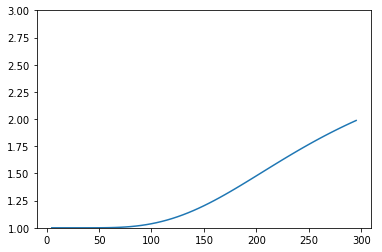

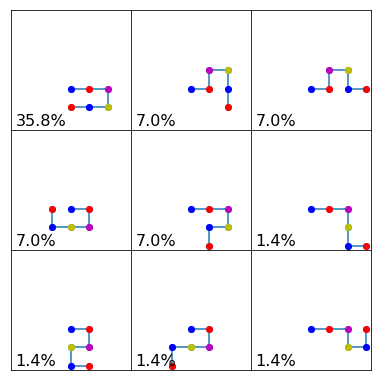

In [280]:
R = 8.3145e-3

Seq = 'KEPAKE'
Confs = generate_positions(len(Seq))
Energy = calculate_energy(Confs, Seq)
Lengths = calculate_length(Confs)


Taxis = np.arange(5, 300, 5)
Laxis = []
Qaxis = []
for T in Taxis:
    Pops, Q = calculate_populations(Energy, T)
    Lbar = np.sum(Lengths*Pops)
    Laxis.append(Lbar)
    Qaxis.append(Q)
    ndcs = np.argsort(-Pops)
    
plt.plot(Taxis, Laxis)
plt.ylim(1, 0.5*len(Seq))
plt.show()

plt.figure(figsize=(5,5))
plot_conformations(Confs[ndcs[0:9],:], Seq, pop=Pops[ndcs[0:9]]*100)

In [245]:
R = 8.3145
Tmax = 373
Tstep = 1
Taxis = np.arange(Tstep, Tmax+Tstep, Tstep)

# kJ/mol
kTaxis = R*Taxis*1e-3

E = calculate_energy(generate_positions(5), [Salt14], [Kink2Right])
Qvals = []
for kT in kTaxis:
    Qvals.append(np.sum(np.exp(-E/kT)))
    
Qvals = np.array(Qvals)
plt.plot(Taxis, Qvals)
plt.ylim(0, np.max(Qvals)*1.1)
plt.ylabel('Partition Function', fontsize=16)

Nlabs = Nlabs
ystep = np.int(np.ceil(np.max(Qvals)/(Nlabs-1)))
plt.yticks(range(0, Nlabs*ystep, ystep), fontsize=16)
plt.plot([Taxis[0], Taxis[-1]], np.shape(E)[0]*np.array([1,1]))
plt.show()

plt.bar(range(0, len(E)), np.exp(-E/(R*298*1e-3))/Q)
plt.show()

TypeError: calculate_energy() takes 2 positional arguments but 3 were given

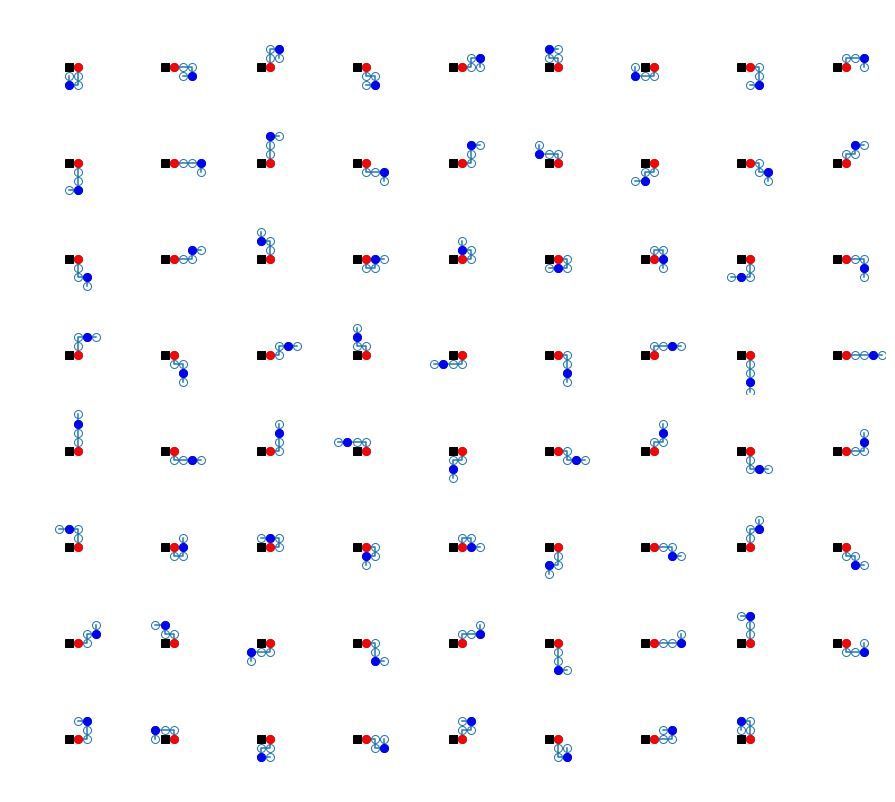

In [133]:
plt.figure(figsize=(12,12))

plot_positions(generate_positions(6), 8, [(1,'ro'), (4,'bo')])

In [128]:
def calculate_energy(PosArray, Pairs, Kinks):
    
    Npos = np.shape(PosArray)[0]
    Energy = np.zeros((Npos,))
    
    # Energy assigned if contact is made
    for p in Pairs:
        Dist = np.abs(PosArray[:,p[0]] - PosArray[:,p[1]])
        Energy += p[2]*(np.abs(Dist-1)<eps)
    
    # Energy assigned if a specific turn is made
    for k in Kinks:
        Move = PosArray[:,k[0]+1] - PosArray[:,k[0]]
        PriorMove = PosArray[:,k[0]] - PosArray[:,k[0]-1]
        Energy += k[2]*(np.abs(Move/PriorMove-k[1])<eps)
            
    return Energy - np.min(Energy)
    
    
Kink1Left = [1,1j,-4]
Kink1Right = [1,1j,-4]
Kink2Right = [2,-1j,-4]
Kink2Left = [2,1j,-4]

Salt03 = [0,3,-4]
Salt14 = [1,4,-4]
Repel03 = [0,3,+1]

calculate_energy(generate_positions(4), [Salt03], [Kink1Left])



array([ 4.,  8.,  4.,  8.,  8.,  4.,  8.,  8.,  0.])